# Case Study: The source of the 1854 cholera outbreak

We'll use modern Python tools to redo John Snow's analysis identifying the source of the 1854 cholera outbreak on London's Broad Street. 

In contrast to his Game of Thrones counterpart, London's John Snow did know something: the source of cholera. He learned it doing the first-ever geospatial analysis!


For this example, we'll use the data from Robin's blog. Robin did the work to digitize Snow's original map and data.

Let's first retrieve the data and unzip it in our current directory:


In [6]:
# !wget http://www.rtwilson.com/downloads/SnowGIS_v2.zip  
# !unzip  SnowGIS_v2.zip

Let's see what's inside:

In [7]:
!ls ./SnowGIS/

Cholera_Deaths.dbf          OSMap_Grayscale.tif.ovr
Cholera_Deaths.prj          Pumps.dbf
Cholera_Deaths.sbn          Pumps.prj
Cholera_Deaths.sbx          Pumps.sbx
Cholera_Deaths.shp          Pumps.shp
Cholera_Deaths.shx          Pumps.shx
OSMap.tfw                   README.txt
OSMap.tif                   SnowMap.tfw
OSMap_Grayscale.tfw         SnowMap.tif
OSMap_Grayscale.tif         SnowMap.tif.aux.xml
OSMap_Grayscale.tif.aux.xml SnowMap.tif.ovr


Ignore the file extensions for a moment, and let's see what we have here.

### Vector Data

- Cholera_Deaths : number of deaths at a given spatial coordinate
- Pumps : location of water pumps


### Raster Data

- OSMap_Grayscale : raster - georeferenced grayscale map of the area from OpenStreet Maps (OSM)
- OSMap : raster - georeferenced map of the area from OpenStreet Maps (OSM)
- SnowMap : raster - digitized and georeferenced John Snow's original map


We can ignore the other files for the raster data and only deal with the '.tif' files. '.tif' is the most common format for storing raster and image data.

In [8]:
# !pip install rasterio
# !pip install contextily

In [9]:
import matplotlib
import geopandas as gpd
import contextily as ctx

## Reading in data

Let's read in the Cholera_Death.shp and Pumps.shp files into geopandas:

In [10]:
deaths_df = gpd.read_file('SnowGIS/Cholera_Deaths.shp')
pumps_df = gpd.read_file('SnowGIS/Pumps.shp')

In [11]:
deaths_df.head()

,Id,Count,geometry
0,0,3,POINT (529308.741 181031.352)
1,0,2,POINT (529312.164 181025.172)
2,0,1,POINT (529314.382 181020.294)
3,0,1,POINT (529317.380 181014.259)
4,0,4,POINT (529320.675 181007.872)


The output looks exactly like a pandas dataframe. The only difference with geopandas' dataframes is the geometry column, which is our vector dataset's essence. In our case, it includes the point coordinates of the deaths as John Snow logged them.

Let's see what the CRS data looks like:

In [12]:
deaths_df.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

The other difference is that correctly defined shapefiles include metadata articulating their Coordinate Reference System (CRS). In this case, it is EPSG:27700.

Let's now briefly look at the pumps data:

In [13]:
pumps_df

,Id,geometry
0,0,POINT (529396.539 181025.063)
1,0,POINT (529192.538 181079.391)
2,0,POINT (529183.740 181193.735)
3,0,POINT (529748.911 180924.207)
4,0,POINT (529613.205 180896.804)
5,0,POINT (529453.586 180826.353)
6,0,POINT (529593.727 180660.455)
7,0,POINT (529296.104 180794.849)


Similarly, pumps_df holds the positions of the water pumps near Broad Street.

Here are the pumps CRS data:

In [14]:
pumps_df.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

**Note** 

When dealing with geospatial data, you should make sure all your sources have the same CRS. I cannot stress this enough. It is probably the most common source of all mistakes when dealing with geospatial data.

#### Plotting the outbreak

We can now plot the deaths and pumps data on a map of London's Broad Street.

We'll start building the plot by first charting deaths:

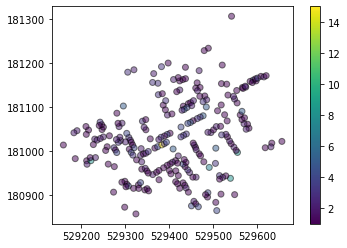

In [15]:
ax = deaths_df.plot(column='Count', alpha=0.5, edgecolor='k', legend=True)


With a reference to `ax`, we can then plot the pumps in their locations, marking them with a red X. Let's also make the figure larger.

<AxesSubplot:>

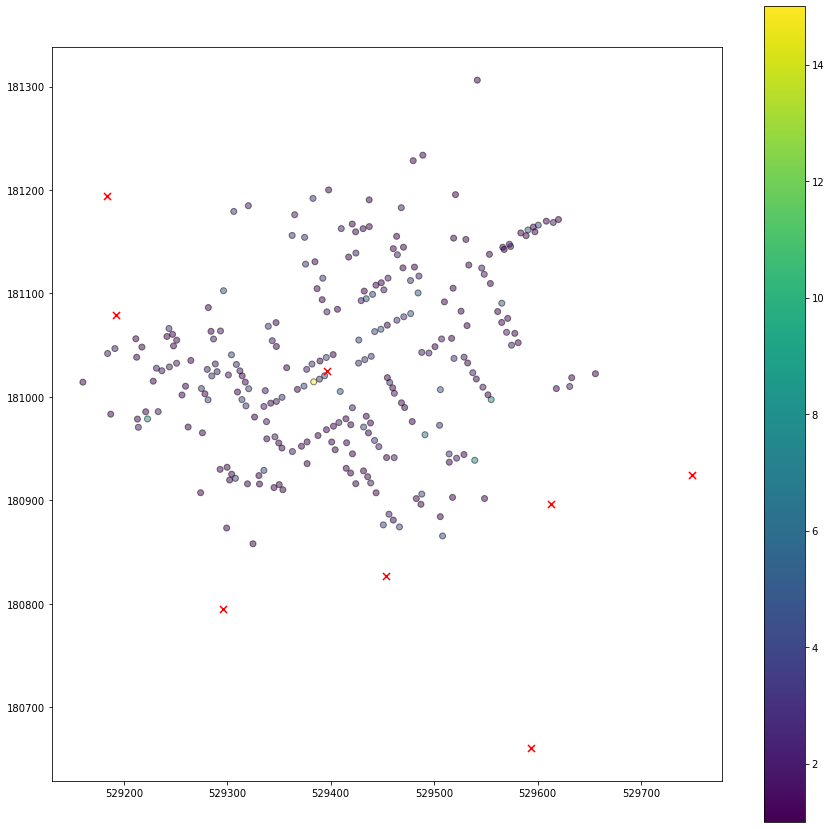

In [17]:
ax = deaths_df.plot(column='Count', figsize=(15, 15), alpha=0.5, edgecolor='k', legend=True)
pumps_df.plot(ax=ax, marker='x', color='red', markersize=50)

We would now like to show a map of London's Broad Street underneath the data. This is where we can use contextily to read the CRS data:

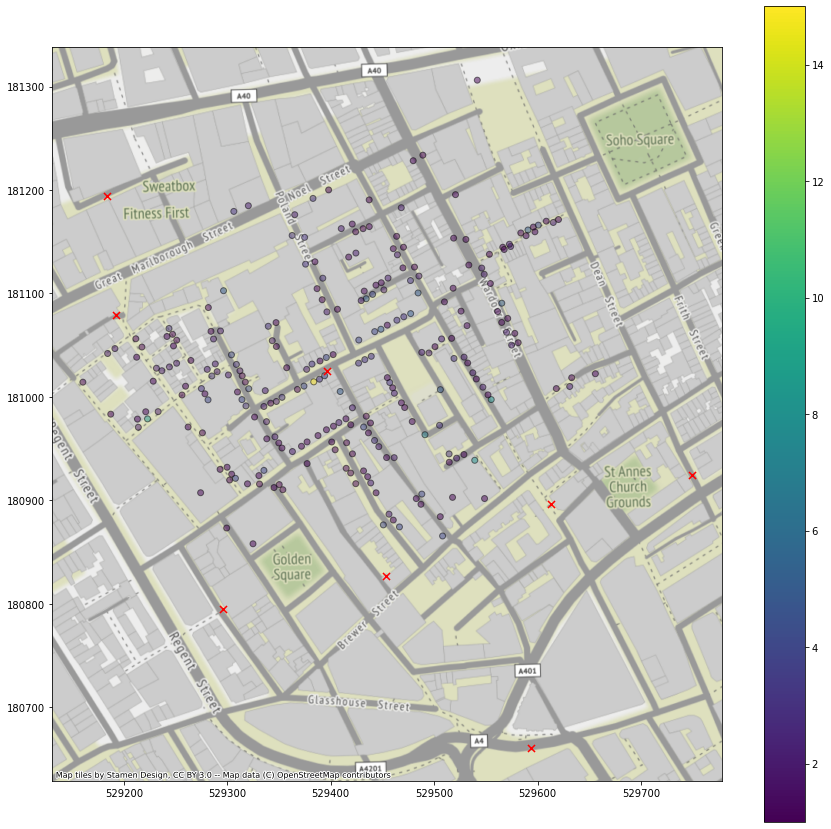

In [18]:
ax = deaths_df.plot(column='Count', figsize=(15, 15), alpha=0.5, edgecolor='k', legend=True)
pumps_df.plot(ax=ax, marker='x', color='red', markersize=50)

ctx.add_basemap(
    ax,
    # CRS definition. Without the line below, the map stops making sense
    crs=deaths_df.crs.to_string(),
)

Now let's look at the same data, but on John Snow's original map. We can do this by changing the source parameter to `SnowMap.tif`, like so:

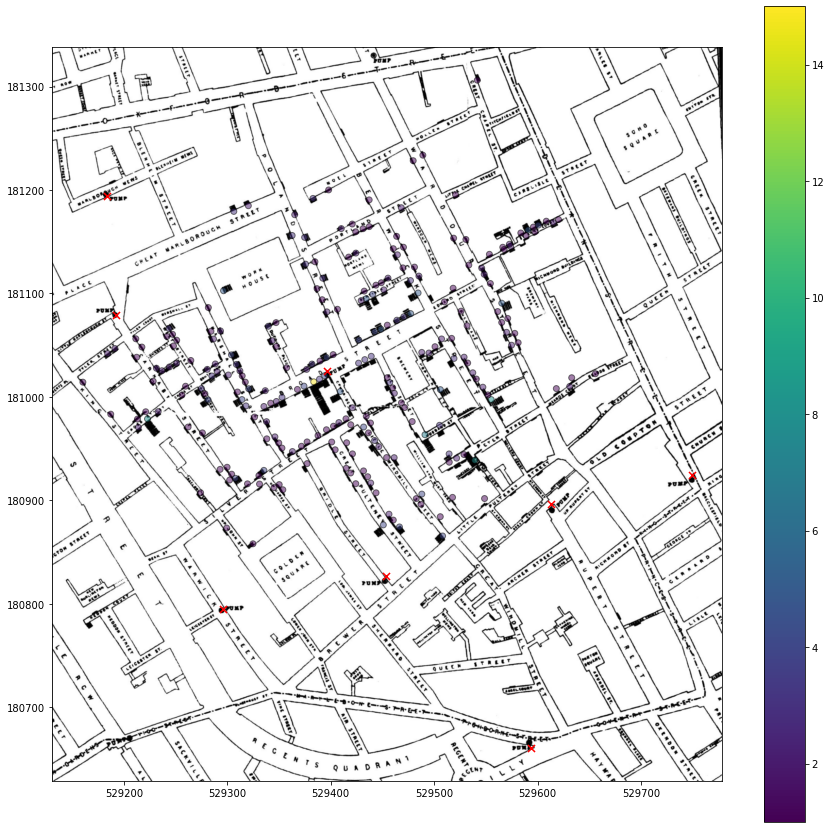

In [19]:
ax = deaths_df.plot(column='Count', figsize=(15, 15), alpha=0.5, edgecolor='k', legend=True)
pumps_df.plot(ax=ax, marker='x', color='red', markersize=50);

ctx.add_basemap(ax,
    crs=deaths_df.crs.to_string(),
    # Using the original map, hand-drawn by Snow
    source="SnowGIS/SnowMap.tif"
)

John Snow understood that most cholera deaths were clustered around a specific water pump at the intersection of Broad Street and Lexington Street (red X near the middle of the map). He attributed the outbreak to an infected water supply at that pump.

It's interesting to see how little the area has changed since 1854.



##  Conclusion

In this notebook, we have had a small glimpse of what you can do with geospatial data:

- We covered the basic notions that you need to understand to work with geospatial data. You should know the difference between a vector vs. raster and between geocoding vs. georeferencing. You also learned about projections, CRSs, and that Africa is HUGE!
- We covered the basics of shapely and geopandas, allowing us to work with geospatial vectors.
- Lastly, we reincarnated the first geospatial analysis. We found the infected water pump that was the source of the 1854 cholera outbreak in London.


Follow us for the following articles where we:

1. dive deeper into geopandas, preparing and analyzing a geospatial dataset
2. do machine learning with geospatial data!


After this series, you'll be ready to carry out your own spatial analysis and identify patterns in our world!

## More Resources
A good place to find free spatial datasets is rtwilson's list of free spatial data sources https://freegisdata.rtwilson.com/ .


You can download free satellite imagery from NASA's portal or Copernicus https://earthdata.nasa.gov/ and https://scihub.copernicus.eu/.